# MAST30034 Applied Data Science Project 2

## Customer Analysis Notebook

In [1]:
from pyspark.sql import SparkSession, functions as F, DataFrame
import matplotlib.pyplot as plt
from turtle import title

In [2]:
spark = (
    SparkSession.builder.appName("Customer_Analysis")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.executor.memory", "2g")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

22/09/11 19:05:26 WARN Utils: Your hostname, Yis-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 172.16.32.216 instead (on interface en0)
22/09/11 19:05:26 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/11 19:05:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
joined_data = spark.read.parquet('../data/curated/joined_data.parquet')

In [4]:
#joined_data.describe()

### Aggregate Data

In [5]:
# By State
transaction_by_state = joined_data \
                    .groupBy("state") \
                    .agg(
                        F.mean("dollar_value").alias("mean_amount"),
                        F.sum("dollar_value").alias("total_amount"),
                        F.count("order_id").alias("order_volume")
                    ) \
                    .orderBy("state") \
                    .toPandas()

# By Postcode
transaction_by_postcode = joined_data \
                    .groupBy("postcode") \
                    .agg(
                        F.mean("dollar_value").alias("mean_amount"),
                        F.sum("dollar_value").alias("total_amount"),
                        F.count("order_id").alias("order_volume")
                    ) \
                    .orderBy("postcode") \
                    .toPandas()

In [6]:
# By Merchant
transaction_by_merchant = joined_data \
                    .groupBy("merchant_abn") \
                    .agg(
                        F.mean("dollar_value").alias("mean_amount"),
                        F.sum("dollar_value").alias("total_amount"),
                        F.count("order_id").alias("order_volume")
                    ) \
                    .orderBy("merchant_abn") \
                    .toPandas()

In [7]:
transaction_by_merchant

,merchant_abn,mean_amount,total_amount,order_volume
0,10023283211,208.750594,172219.240413,825
1,10142254217,40.039770,30870.662772,771
2,10187291046,110.326191,9708.704810,88
3,10192359162,451.143208,48272.323259,107
4,10206519221,38.234392,92986.040503,2432
...,...,...,...,...
4354,99938978285,30.029723,132971.614185,4428
4355,99974311662,319.209608,10533.917066,33
4356,99976658299,150.166184,907904.749365,6046
4357,99987905597,353.519570,15908.380664,45


### Transaction By State

<AxesSubplot:title={'center':'Average Amount($)'}, ylabel='state'>

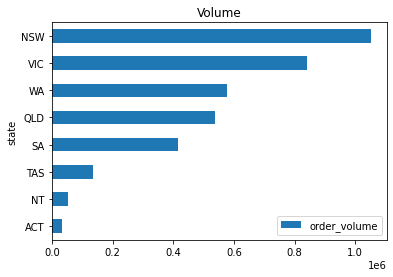

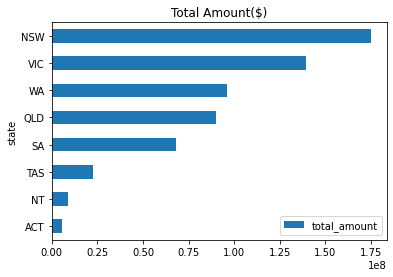

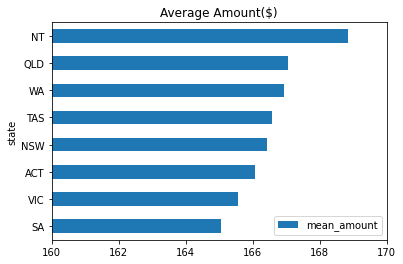

In [13]:
transaction_by_state = transaction_by_state.sort_values(by='order_volume')
transaction_by_state.plot(x='state', y='order_volume', kind="barh", title='Volume')
transaction_by_state = transaction_by_state.sort_values(by='total_amount')
transaction_by_state.plot(x='state', y='total_amount', kind="barh", title='Total Amount($)')
transaction_by_state = transaction_by_state.sort_values(by='mean_amount')
transaction_by_state.plot(x='state', y='mean_amount', kind="barh", xlim=[160,170], title='Average Amount($)')

### Transaction Volume By Postcode (Top 10)

<AxesSubplot:ylabel='postcode'>

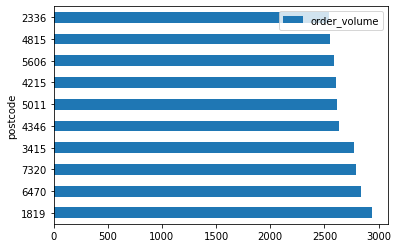

In [9]:
transaction_by_postcode = transaction_by_postcode.sort_values(by='order_volume', ascending=False)
transaction_by_postcode[:10].plot(x='postcode', y='order_volume', kind="barh")

### Transaction Volume By Merchant (Top 10)

<AxesSubplot:ylabel='merchant_abn'>

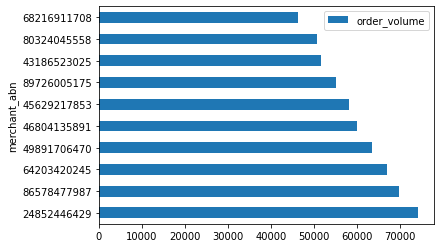

In [10]:
transaction_by_merchant = transaction_by_merchant.sort_values(by='order_volume', ascending=False)
transaction_by_merchant[:10].plot(x='merchant_abn', y='order_volume', kind="barh")

### Geospatial Visualisation (Need ABS SA2 Data)

### Distribution of dollar value

In [14]:
import seaborn as sns
less_than_2000 = joined_data[ joined_data['dollar_value'] < 2000 ]
sns.displot(less_than_2000, x="dollar_value", kind="kde", cut = 0)

ValueError: Cannot convert column into bool: please use '&' for 'and', '|' for 'or', '~' for 'not' when building DataFrame boolean expressions.

### Time of year
(All instances are from 2021)

In [ ]:
import pyspark.sql.functions as F
joined_data = spark.read.parquet('../data/curated/joined_data.parquet')
joined_data = joined_data.withColumn('date', F.regexp_replace('order_datetime', r'(\d{4})-', ''))
joined_data = joined_data.withColumn('year', F.regexp_replace('order_datetime', r'(-\d{2}-\d{2})', ''))

joined_data.groupBy("date").sum('dollar_value')

date_df = joined_data[['date', 'dollar_value']] \
                .groupby('date') \
                .agg(
                    {
                        'dollar_value': 'sum', 
                        'date': 'count'
                    }
                )
date_df = date_df.withColumn('avg_dollar_value', date_df['sum(dollar_value)'] / date_df['count(date)'])
date_df.drop('sum(dollar_value)', 'count(date)')
date_df = date_df.toPandas()

date_df = date_df.sort_values(by = ['date'])
x = date_df['date']
y = date_df['avg_dollar_value']

# plotting
import matplotlib.pyplot as plt
from matplotlib import pyplot
import pandas as pd
fig, ax = plt.subplots(figsize=(12,8))
time_df = pd.DataFrame({"date": x, "avg_dollar_value":y})
time_df.plot(kind='scatter', x= 'date', y= 'avg_dollar_value', fontsize = 12, ax=ax, legend = False) 
ax.set_title('Average Dollar Value throughout the year', fontsize = 20)
ax.set_xlabel("Date", fontsize = 15)
xticks = ax.get_xticks()
ax.set_xticks(xticks[::len(xticks) // 10])
ax.set_ylabel("Average Amount", fontsize = 15)

### Day of the week

In [ ]:
joined_data = pd.read_parquet('../data/curated/joined_data.parquet')
joined_data['order_datetime'] = pd.to_datetime(joined_data['order_datetime'])
joined_data['day_of_week'] = joined_data['order_datetime'].dt.day_name()

date_df = joined_data[['day_of_week', 'dollar_value']] \
                .groupby('day_of_week') \
                .agg(
                    {
                        'dollar_value': 'sum', 
                        'day_of_week': 'count'
                    }
                )

date_df['avg_dollar_value'] = date_df['dollar_value']/date_df['day_of_week']
date_df = date_df.drop(columns = ['dollar_value', 'day_of_week'])
#date_df = date_df.drop('day_of_week_count')
#date_df.rename(columns = {'day_of_week':'count'})
#date_df['count'] = date_df['day_of_week']
#date_df.drop('day_of_week')
#date_df
date_df = date_df.reset_index()
dotw = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
date_df['Date'] = pd.Categorical(date_df['day_of_week'], categories=dotw, ordered=True)
date_df = date_df.sort_values('Date')

x = date_df['day_of_week']
y = date_df['avg_dollar_value']

# plotting
import matplotlib.pyplot as plt
from matplotlib import pyplot
import pandas as pd
fig, ax = plt.subplots(figsize=(12,8))
time_df = pd.DataFrame({"day_of_week": x, "avg_dollar_value":y})
time_df.plot(kind='bar', x= 'day_of_week', y= 'avg_dollar_value', fontsize = 12, ax=ax, legend = False) 
ax.set_title('Average Dollar Value throughout the year', fontsize = 20)
ax.set_xlabel("Date", fontsize = 15)
xticks = ax.get_xticks()
ax.set_ylabel("Average Amount", fontsize = 15)